In [1]:
!pip install segmentation_models_pytorch

from fastai.vision import *
from PIL import Image as PImage
import cv2
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
import glob
import cv2
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, sampler
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
import os
#import pdb
import time
import warnings
import random
import concurrent.futures
# warning print supression
warnings.filterwarnings("ignore")

seed = 12
random.seed(seed)
torch.manual_seed(seed)

     |████████████████████████████████| 42 kB 255 kB/s 
     |████████████████████████████████| 58 kB 1.5 MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=5b71819c5dade14924dd260fb72ecbc59922135654bc1bb380cb624bb8f93d67
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-py3-none-any.whl size=16035 sha256=4af99d988db1bf60ef4c7715ccca85aa6e540a45ffa473967257b7af622205fb
  Stored in directory: /root/.cache/pip/wheels/b7/cc/0d/41d384b0071c6f46e542aded5f8571700ace4f1eb3f1591c29
Successfully built pretrainedmodels efficientnet-pytorch
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [ ]:
## Predictor model is implemented using guidance from from https://medium.com/analytics-vidhya/pytorch-implementation-of-semantic-segmentation-for-single-class-from-scratch-81f96643c98c

In [ ]:
# List of images
ims = glob.glob('/input/opencitiestrain/data/images-256/*.png')
df = pd.DataFrame({
    'img_path':ims,
    'mask_path':[im.replace('images', 'masks').replace('.png', '_mask.png') for im in ims],
    'valid':False
})
# Add columns
df['img_id'] = df['img_path'].apply(lambda x: x.split('/input/opencitiestrain/data/images-256/')[1].split(".png")[0])
df['scene_id'] = df['img_path'].apply(lambda x: x.split("_")[1])
df['area'] = df['img_path'].apply(lambda x: x.split("_")[0].split("/")[-1])
df['prot'] = 0
df.loc[df['area'] == 'dar', 'prot'] = 1


In [4]:
# Set random validation set
df.loc[df.sample(n=5000, random_state=39).index, 'valid'] = 'True'
df_valid = df[df.valid == 'True']
df_train = df[df.valid != 'True']

In [6]:
# Convert the high resolution image mask to 128*128
!mkdir train_masks-128
def resize_mask(fn):
    PIL.Image.open('/input/opencitiestrain/data/masks-256/' + fn + '_mask.png').resize((128,128), resample=PIL.Image.NEAREST).save('train_masks-128/' + fn + '_mask.png')

files = list(df['img_id'])
with concurrent.futures.ThreadPoolExecutor(8) as e: e.map(resize_mask, files)

# Convert the high resolution input image to 128*128
!mkdir train-128
def resize_img(fn):
    PIL.Image.open('/input/opencitiestrain/data/images-256/' + fn + '.png').resize((128,128)).save('train-128/' + fn + '.png')

files = list(df['img_id'])
with concurrent.futures.ThreadPoolExecutor(8) as e: e.map(resize_img, files)

In [7]:
# location of original and mask image
img_fol='train-128/'
mask_fol='train_masks-128/'
# imagenet mean/std will be used as the resnet backbone is trained on imagenet stats
mean, std=(0.485, 0.456, 0.406),(0.229, 0.224, 0.225)

In [9]:
'''when dataloader requests for samples using index, fetch and return input image and target mask'''
class ImgDataset(Dataset):
    def __init__(self,df,img_fol,mask_fol,mean,std,phase):
        self.fname=df['img_id'].values.tolist()
        self.prot=df['prot'].values.tolist()
        self.img_fol=img_fol
        self.mask_fol=mask_fol
        self.mean=mean
        self.std=std
        self.phase=phase
    def __getitem__(self, idx):
        name=self.fname[idx]
        prot=self.prot[idx] 
        prot_tensor = torch.Tensor(128)
        prot_tensor = prot_tensor.fill_(prot)
        img_name_path=os.path.join(self.img_fol,name)
        img_name_path = img_name_path + '.png'
        mask_name_path=img_name_path.split('.')[0].replace('train-128','train_masks-128')+'_mask.png'
        img=cv2.imread(img_name_path)
        mask=cv2.imread(mask_name_path,cv2.IMREAD_GRAYSCALE)
        mask = mask.transpose()
        mask = mask/255
        mask = np.expand_dims(mask, axis=0)
        img = img.transpose()
        return img, mask, prot_tensor, name

    def __len__(self):
        return len(self.fname)

In [10]:
def ImgDataloader(df_train,df_valid,img_fol,mask_fol,mean,std,phase,batch_size):
    df = df_train if phase=='train' else df_valid
    for_loader=ImgDataset(df, img_fol, mask_fol, mean, std, phase)
    dataloader=DataLoader(for_loader, batch_size=batch_size, pin_memory = False)

    return dataloader

In [11]:
# Define the adversarial model by adding new adversary layers to the pre-trained predictor model

pretrained_unet = smp.Unet("resnet18", encoder_weights="imagenet", classes=1, activation=None)

class Adv(nn.Module):
    def __init__(self, pretrained_unet):
        super(Adv, self).__init__()
        self.pretrained = pretrained_unet
        self.new_layers = nn.Sequential(nn.Linear(128, 1))
        self.new_layers.c = torch.nn.Parameter(torch.randn(1))
    
    def forward(self, x, y):
        x = self.pretrained(x)
        y_pred = torch.sigmoid(x)
        #y_pred = torch.squeeze(y_pred)
        y = torch.squeeze(y)
        s = torch.sigmoid((1 + torch.abs(self.new_layers.c)) * torch.squeeze(y_pred))
        s_vec = torch.stack([s, s*y, s*(1-y)], dim=1)
        s_vec = torch.sum(s_vec, 1)
        z_pred = torch.sigmoid(self.new_layers(s_vec))
        z_pred = torch.squeeze(z_pred)
        return y_pred, z_pred


Adv_model = Adv(pretrained_unet)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


Adversarial updates to all layers, run for a=1 and a=500

In [12]:
class Trainer(object):
    def __init__(self,model):
        self.num_workers=4
        self.batch_size={'train':64, 'val':1}
        self.accumulation_steps= 1 
        self.lr=0.001
        self.num_epochs=5
        self.phases=['train','val']
        self.best_loss=float('inf')
        self.device=torch.device("cuda:0")
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
        self.net=model.to(self.device)
        self.criterion=torch.nn.BCELoss()
        self.criterion_A = torch.nn.BCELoss()
        self.optimizer=optim.Adam(self.net.pretrained.parameters(),lr=self.lr)
        self.optimizer_A=optim.Adam(self.net.new_layers.parameters(),lr=self.lr)
        self.dataloaders={phase: ImgDataloader(df_train, df_valid, img_fol,
                                               mask_fol, mean, std,
                                               phase=phase,batch_size=self.batch_size[phase]) for phase in self.phases}

        self.losses={phase:[] for phase in self.phases}
        self.jacc_score={phase:[] for phase in self.phases}

    def iterate(self, epoch, phase):
        #measure=Scores(phase, epoch)
        start=time.strftime("%H:%M:%S")
        print (f"Starting epoch: {epoch} | phase:{phase} | Start Time: {start}")
        batch_size=self.batch_size[phase]
        self.net.train(phase=="train")
        dataloader=self.dataloaders[phase]
        running_loss=0.0
        running_loss_A = 0.0
        total_batches=len(dataloader)
        n_itr = 0
        
        print("a: ", a)
        
        for itr,batch in enumerate(dataloader):
            n_itr +=1
            # 1. Train Adversary
            self.optimizer_A.zero_grad()
            images,mask_target, prot, name =batch
            prot = prot.float()
            prot = prot.to(self.device)
            inp_images=images.float() 
            inp_images=inp_images.to(self.device)
            tar_mask=mask_target.to(self.device)
            tar_mask=tar_mask.float()
            pred_mask, z_pred = Adv_model.forward(inp_images, tar_mask)
            loss_A = self.criterion_A(z_pred, prot)
            if phase == 'train':
                loss_A.backward(retain_graph=True)
                grads = []
                for name, param in self.net.pretrained.named_parameters():
                    grads.append(param.grad)
                # Alternative updates between Adversary and Predictor
                if itr == 0:
                    self.optimizer_A.step()
                elif (itr % d) == 0:
                    self.optimizer_A.step()
            # Keep track of adversary loss
            running_loss_A += loss_A.item()
            
            # 2. Train Predictor
            # Zero gradients
            self.optimizer.zero_grad()   
            loss=self.criterion(pred_mask,tar_mask)
            if phase=='train':
                if (itr % d) != 0:
                    loss.backward()
                    # Perform backprop on the predictor loss, update the gradients based on the expression in Zhang et al.
                    for i, param in enumerate(self.net.pretrained.parameters()):
                        unit_protect = torch.norm(grads[i])
                        param.grad -= a* grads[i]
                        param.grad -= a* torch.sum(param.grad * unit_protect) * unit_protect
                    self.optimizer.step()

            # Keep track of predictor loss
            running_loss+=loss.item()
            pred_mask=pred_mask.detach().cpu()                
            
        epoch_loss=(running_loss*self.accumulation_steps)/total_batches
        print("Loss: ", epoch_loss)
        self.losses[phase].append(epoch_loss)
        torch.cuda.empty_cache()
        return epoch_loss
    def start(self):
        for epoch in range (self.num_epochs):
            self.iterate(epoch,"train")
            state = {
                "epoch": epoch,
                "best_loss": self.best_loss,
                "state_dict": self.net.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            }
            with torch.no_grad():
                val_loss=self.iterate(epoch,"val")
            if val_loss < self.best_loss:
                print("******** New optimal found, saving state ********")
                state["best_loss"] = self.best_loss = val_loss
                torch.save(state, "./adv.pth")
            print ()
    
    

Starting epoch: 0 | phase:train | Start Time: 08:56:18
a:  1
Loss:  0.546365236088992
Starting epoch: 0 | phase:val | Start Time: 08:57:40
a:  1
Loss:  0.5423396027684212
******** New optimal found, saving state ********

Starting epoch: 1 | phase:train | Start Time: 08:58:33
a:  1
Loss:  0.546365236088992
Starting epoch: 1 | phase:val | Start Time: 08:59:51
a:  1
Loss:  0.5423396027684212

Starting epoch: 2 | phase:train | Start Time: 09:00:43
a:  1
Loss:  0.546365236088992
Starting epoch: 2 | phase:val | Start Time: 09:02:00
a:  1
Loss:  0.5423396027684212

Starting epoch: 3 | phase:train | Start Time: 09:02:53
a:  1
Loss:  0.546365236088992
Starting epoch: 3 | phase:val | Start Time: 09:04:10
a:  1
Loss:  0.5423396027684212

Starting epoch: 4 | phase:train | Start Time: 09:05:02
a:  1
Loss:  0.546365236088992
Starting epoch: 4 | phase:val | Start Time: 09:06:19
a:  1
Loss:  0.5423396027684212

Overall Accuracy:  0.7690354125976563
F1:  0.16362844304051785
Jaccard Score:  0.711273258

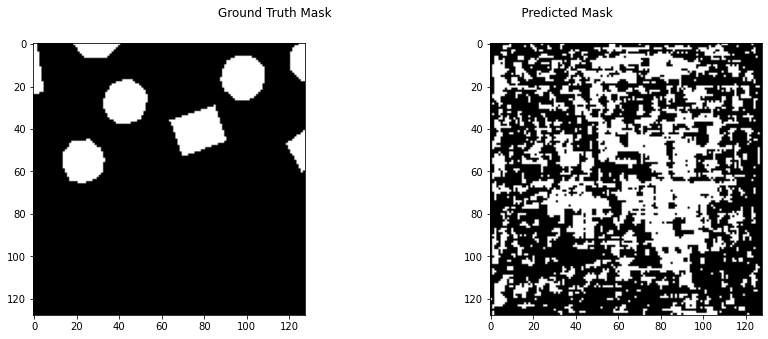

Starting epoch: 0 | phase:train | Start Time: 09:11:46
a:  500
Loss:  0.2701790885826976
Starting epoch: 0 | phase:val | Start Time: 09:13:03
a:  500
Loss:  0.23070658701658248
******** New optimal found, saving state ********

Starting epoch: 1 | phase:train | Start Time: 09:13:56
a:  500
Loss:  0.2510774938511275
Starting epoch: 1 | phase:val | Start Time: 09:15:13
a:  500
Loss:  0.5469856551557779

Starting epoch: 2 | phase:train | Start Time: 09:16:05
a:  500
Loss:  0.28907836405272336
Starting epoch: 2 | phase:val | Start Time: 09:17:21
a:  500
Loss:  0.2783592828847468

Starting epoch: 3 | phase:train | Start Time: 09:18:13
a:  500
Loss:  0.29110713103382857
Starting epoch: 3 | phase:val | Start Time: 09:19:30
a:  500
Loss:  0.26854513179287315

Starting epoch: 4 | phase:train | Start Time: 09:20:22
a:  500
Loss:  0.2871349230152635
Starting epoch: 4 | phase:val | Start Time: 09:21:39
a:  500
Loss:  0.29462904295623304

Overall Accuracy:  0.9199385009765625
F1:  0.026997524559320

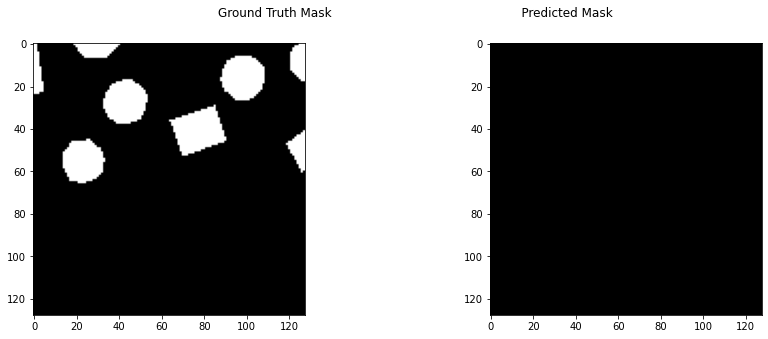

In [13]:
a_range = [1, 500]

for a in a_range:
    d=2
    a = a
    Adv_model = Adv(pretrained_unet)
    model_trainer = Trainer(Adv_model)
    model_trainer.start()
    
    test_dataloader=ImgDataloader(df_train, df_valid,img_fol,mask_fol,mean,std,'val',1)

    ckpt_path='adv.pth'

    device = torch.device("cuda")
    model = Adv(pretrained_unet)
    model.to(device)
    model.eval()
    state = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
    model.load_state_dict(state["state_dict"])

    # start prediction
    predictions = []
    masks = []
    names = []
    for i, batch in enumerate(test_dataloader):
        images,mask_target, prot, name = batch
        images = images.float()
        mask_target = mask_target.float()
        batch_preds, batch_z_preds = model(images, mask_target)
        batch_preds = torch.round(batch_preds)
        batch_preds = batch_preds.detach().cpu().numpy()
        predictions.append(batch_preds)
        mask = mask_target.detach().cpu().numpy()
        masks.append(mask)
        names.append(name)
    
    dar_indx = np.where(df_valid["area"] == "dar")[0].tolist()

    pred_arrs_s = np.vstack(predictions)
    y_arrs_s = np.vstack(masks)

    acc = accuracy_score(y_arrs_s.flatten(), pred_arrs_s.flatten())
    f1 = f1_score(y_arrs_s.flatten(), pred_arrs_s.flatten())
    jacc = jaccard_score(y_arrs_s.flatten(), pred_arrs_s.flatten(), average='weighted')

    print("Overall Accuracy: ", acc)
    print("F1: ", f1)
    print("Jaccard Score: ", jacc)

    pred_arrs_other = []
    y_arrs_other = []
    for i, pred in enumerate(predictions):
      if i not in dar_indx:
        pred_arrs_other.append(predictions[i])
        y_arrs_other.append(masks[i])

    pred_arrs_s_other = np.vstack(pred_arrs_other)
    y_arrs_s_other = np.vstack(y_arrs_other)

    other_acc = accuracy_score(y_arrs_s_other.flatten(), pred_arrs_s_other.flatten())
    other_f1 = f1_score(y_arrs_s_other.flatten(), pred_arrs_s_other.flatten())
    other_jacc = jaccard_score(y_arrs_s_other.flatten(), pred_arrs_s_other.flatten(), average='weighted')

    print("Accuracy for other area: ", other_acc)
    print("F1 for other area: ", other_f1)
    print("Jaccard score for other area: ", other_jacc)

    pred_arrs_dar = []
    y_arrs_dar = []
    for i in dar_indx:
      pred_arrs_dar.append(predictions[i])
      y_arrs_dar.append(masks[i])

    pred_arrs_s_dar = np.vstack(pred_arrs_dar)
    y_arrs_s_dar = np.vstack(y_arrs_dar)

    dar_acc = accuracy_score(y_arrs_s_dar.flatten(), pred_arrs_s_dar.flatten())
    dar_f1 = f1_score(y_arrs_s_dar.flatten(), pred_arrs_s_dar.flatten())
    dar_jacc = jaccard_score(y_arrs_s_dar.flatten(), pred_arrs_s_dar.flatten(), average='weighted')

    print("Accuracy for dar area: ", dar_acc)
    print("F1 for dar area: ", dar_f1)
    print("Jaccard score for dar area: ", dar_jacc)

    FP_prot = np.sum( (y_arrs_s_dar==0) * (pred_arrs_s_dar==1) )
    FP_other = np.sum( (y_arrs_s_other==0) * (pred_arrs_s_other==1) )
    TP_prot = np.sum( (y_arrs_s_dar==1) * (pred_arrs_s_dar==1) )
    TP_other = np.sum( (y_arrs_s_other==1) * (pred_arrs_s_other==1) )
    FN_prot = np.sum( (y_arrs_s_dar==1) * (pred_arrs_s_dar==0) )
    FN_other = np.sum( (y_arrs_s_other==1) * (pred_arrs_s_other==0) )
    TN_prot = np.sum( (y_arrs_s_dar==0) * (pred_arrs_s_dar==0) )
    TN_other = np.sum( (y_arrs_s_other==0) * (pred_arrs_s_other==0) )
    FPR_prot = FP_prot/ (FP_prot + TN_prot)
    FPR_other = FP_other/ (FP_other + TN_other)
    FNR_prot = FN_prot/ (FN_prot + TP_prot)
    FNR_other = FN_other/ (FN_other + TP_other)

    FPR_diff = FPR_other - FPR_prot
    FNR_diff = FNR_other - FNR_prot

    print("Protected Group: Dar")

    print("FPR Prot: ", FPR_prot)
    print("FPR Other: ", FPR_other)
    print("FNR Prot: ", FNR_prot)
    print("FNR Other: ", FNR_other)

    eq_odds = (np.absolute(FPR_diff) + np.absolute(FNR_diff))/2
    print(eq_odds)
    
    index = names.index(('znz_33cae6_652_19_319396_270504',))
    
    fig, (ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
    fig.suptitle('                Ground Truth Mask                                                 Predicted Mask')
    orig_array = np.reshape(masks[index], (128,128))
    orig_array = np.round(orig_array)
    orig_array = np.rot90(orig_array, k=3)
    orig_array = np.flip(orig_array, axis=1)
    ax1.imshow(np.squeeze(orig_array),cmap='gray')
    pred_array = np.reshape(predictions[index], (128,128))
    pred_array = np.round(pred_array)
    pred_array = np.rot90(pred_array, k=3)
    pred_array = np.flip(pred_array, axis=1)
    ax2.imshow(np.squeeze(pred_array),cmap='gray')
    plt.show()


Adversarial updates to final layers of the encoder and segmentation head only, run for a=1 and a=500

In [14]:
class Trainer(object):
    def __init__(self,model):
        self.num_workers=4
        self.batch_size={'train':64, 'val':1}
        self.accumulation_steps= 1 
        self.lr=0.001
        self.num_epochs=5
        self.phases=['train','val']
        self.best_loss=float('inf')
        self.device=torch.device("cuda:0")
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
        self.net=model.to(self.device)
        self.criterion=torch.nn.BCELoss()
        self.criterion_A = torch.nn.BCELoss()
        self.optimizer=optim.Adam(self.net.pretrained.parameters(),lr=self.lr)
        self.optimizer_A=optim.Adam(self.net.new_layers.parameters(),lr=self.lr)
        self.dataloaders={phase: ImgDataloader(df_train, df_valid, img_fol,
                                               mask_fol, mean, std,
                                               phase=phase,batch_size=self.batch_size[phase]) for phase in self.phases}

        self.losses={phase:[] for phase in self.phases}
        self.jacc_score={phase:[] for phase in self.phases}

    def iterate(self, epoch, phase):
        #measure=Scores(phase, epoch)
        start=time.strftime("%H:%M:%S")
        print (f"Starting epoch: {epoch} | phase:{phase} | Start Time: {start}")
        batch_size=self.batch_size[phase]
        self.net.train(phase=="train")
        dataloader=self.dataloaders[phase]
        running_loss=0.0
        running_loss_A = 0.0
        total_batches=len(dataloader)
        n_itr = 0
        
        print("a: ", a)
        
        for itr,batch in enumerate(dataloader):
            n_itr +=1
            #a = 0.1 * np.sqrt(itr)
            # 1. Train Adversary
            self.optimizer_A.zero_grad()
            images,mask_target,prot,name=batch
            prot = prot.float()
            prot = prot.to(self.device)
            inp_images=images.float() 
            inp_images=inp_images.to(self.device)
            tar_mask=mask_target.to(self.device)
            tar_mask=tar_mask.float()
            pred_mask, z_pred = Adv_model.forward(inp_images, tar_mask)
            loss_A = self.criterion_A(z_pred, prot)
            if phase == 'train':
                loss_A.backward(retain_graph=True)
                grads = []
                seg_grads = []
                for name, param in self.net.pretrained.encoder.layer4.named_parameters():
                    grads.append(param.grad)
                for name, param in self.net.pretrained.segmentation_head.named_parameters():
                    seg_grads.append(param.grad)
                # Alternative updates between Adversary and Predictor
                if itr == 0:
                    self.optimizer_A.step()
                elif (itr % d) == 0:
                    self.optimizer_A.step()
            # Keep track of adversary loss
            running_loss_A += loss_A.item()
            
            # 2. Train Predictor
            # Zero gradients
            self.optimizer.zero_grad()   
            loss=self.criterion(pred_mask,tar_mask)
            if phase=='train':
                if (itr % d) != 0:
                    loss.backward()
                    # Perform backprop on the predictor loss, update the gradients based on the expression in Zhang et al.
                    for i, param in enumerate(self.net.pretrained.encoder.layer4.parameters()):
                        unit_protect = torch.norm(grads[i])
                        param.grad -= a* grads[i]
                        param.grad -= a* torch.sum(param.grad * unit_protect) * unit_protect
                    for i, param in enumerate(self.net.pretrained.segmentation_head.parameters()):
                        unit_protect = torch.norm(seg_grads[i])
                        param.grad -= a* seg_grads[i]
                        param.grad -= a* torch.sum(param.grad * unit_protect) * unit_protect
                    self.optimizer.step()

            # Keep track of predictor loss
            running_loss+=loss.item()
            pred_mask=pred_mask.detach().cpu()                
            
        epoch_loss=(running_loss*self.accumulation_steps)/total_batches
        print("Loss: ", epoch_loss)
        self.losses[phase].append(epoch_loss)
        torch.cuda.empty_cache()
        return epoch_loss
    def start(self):
        for epoch in range (self.num_epochs):
            self.iterate(epoch,"train")
            state = {
                "epoch": epoch,
                "best_loss": self.best_loss,
                "state_dict": self.net.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            }
            with torch.no_grad():
                val_loss=self.iterate(epoch,"val")
            if val_loss < self.best_loss:
                print("******** New optimal found, saving state ********")
                state["best_loss"] = self.best_loss = val_loss
                torch.save(state, "./adv.pth")
            print ()

Starting epoch: 0 | phase:train | Start Time: 09:26:51
a:  1
Loss:  0.1788151723515127
Starting epoch: 0 | phase:val | Start Time: 09:28:07
a:  1
Loss:  0.14193830627128481
******** New optimal found, saving state ********

Starting epoch: 1 | phase:train | Start Time: 09:28:59
a:  1
Loss:  0.14146050575262903
Starting epoch: 1 | phase:val | Start Time: 09:30:15
a:  1
Loss:  0.127449964318797
******** New optimal found, saving state ********

Starting epoch: 2 | phase:train | Start Time: 09:31:07
a:  1
Loss:  0.12745091700574376
Starting epoch: 2 | phase:val | Start Time: 09:32:23
a:  1
Loss:  0.1793352540156804

Starting epoch: 3 | phase:train | Start Time: 09:33:14
a:  1
Loss:  0.11153156534349386
Starting epoch: 3 | phase:val | Start Time: 09:34:30
a:  1
Loss:  0.1065458810031414
******** New optimal found, saving state ********

Starting epoch: 4 | phase:train | Start Time: 09:35:21
a:  1
Loss:  0.10859113650018816
Starting epoch: 4 | phase:val | Start Time: 09:36:37
a:  1
Loss:  0

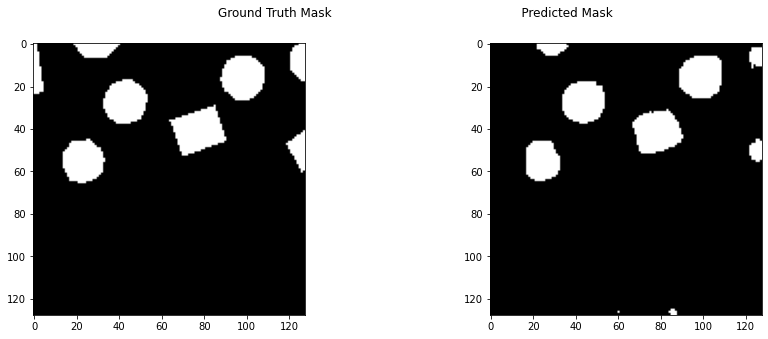

Starting epoch: 0 | phase:train | Start Time: 09:41:43
a:  500
Loss:  0.10581561003866065
Starting epoch: 0 | phase:val | Start Time: 09:42:58
a:  500
Loss:  0.10102572898706422
******** New optimal found, saving state ********

Starting epoch: 1 | phase:train | Start Time: 09:43:49
a:  500
Loss:  0.1040962647992311
Starting epoch: 1 | phase:val | Start Time: 09:45:05
a:  500
Loss:  0.09531117080813274
******** New optimal found, saving state ********

Starting epoch: 2 | phase:train | Start Time: 09:45:56
a:  500
Loss:  0.0978415734502663
Starting epoch: 2 | phase:val | Start Time: 09:47:12
a:  500
Loss:  0.10282345746478531

Starting epoch: 3 | phase:train | Start Time: 09:48:04
a:  500
Loss:  0.09683558735292393
Starting epoch: 3 | phase:val | Start Time: 09:49:19
a:  500
Loss:  0.1019109923776472

Starting epoch: 4 | phase:train | Start Time: 09:50:10
a:  500
Loss:  0.09425075303545523
Starting epoch: 4 | phase:val | Start Time: 09:51:26
a:  500
Loss:  0.10020845445436426

Overall 

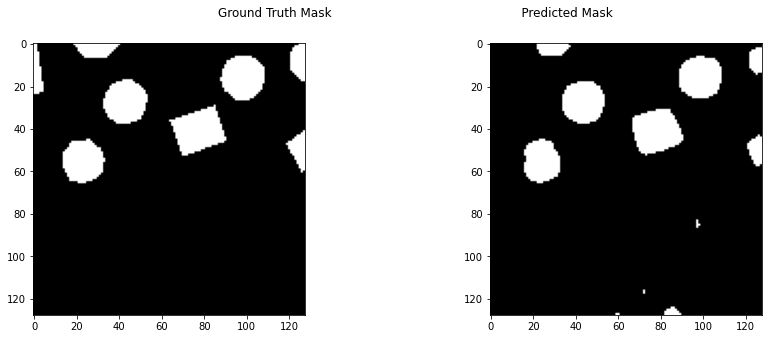

In [15]:
a_range = [1, 500]

for a in a_range:
    d=2
    a = a
    Adv_model = Adv(pretrained_unet)
    model_trainer = Trainer(Adv_model)
    model_trainer.start()
    
    test_dataloader=ImgDataloader(df_train, df_valid,img_fol,mask_fol,mean,std,'val',1)

    ckpt_path='adv.pth'

    device = torch.device("cuda")
    model = Adv(pretrained_unet)
    model.to(device)
    model.eval()
    state = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
    model.load_state_dict(state["state_dict"])

    # start prediction
    predictions = []
    masks = []
    names = []
    for i, batch in enumerate(test_dataloader):
        images,mask_target, prot, name = batch
        images = images.float()
        mask_target = mask_target.float()
        batch_preds, batch_z_preds = model(images, mask_target)
        batch_preds = torch.round(batch_preds)
        batch_preds = batch_preds.detach().cpu().numpy()
        predictions.append(batch_preds)
        mask = mask_target.detach().cpu().numpy()
        masks.append(mask)
        names.append(name)
    
    dar_indx = np.where(df_valid["area"] == "dar")[0].tolist()

    pred_arrs_s = np.vstack(predictions)
    y_arrs_s = np.vstack(masks)

    acc = accuracy_score(y_arrs_s.flatten(), pred_arrs_s.flatten())
    f1 = f1_score(y_arrs_s.flatten(), pred_arrs_s.flatten())
    jacc = jaccard_score(y_arrs_s.flatten(), pred_arrs_s.flatten(), average='weighted')

    print("Overall Accuracy: ", acc)
    print("F1: ", f1)
    print("Jaccard Score: ", jacc)

    pred_arrs_other = []
    y_arrs_other = []
    for i, pred in enumerate(predictions):
      if i not in dar_indx:
        pred_arrs_other.append(predictions[i])
        y_arrs_other.append(masks[i])

    pred_arrs_s_other = np.vstack(pred_arrs_other)
    y_arrs_s_other = np.vstack(y_arrs_other)

    other_acc = accuracy_score(y_arrs_s_other.flatten(), pred_arrs_s_other.flatten())
    other_f1 = f1_score(y_arrs_s_other.flatten(), pred_arrs_s_other.flatten())
    other_jacc = jaccard_score(y_arrs_s_other.flatten(), pred_arrs_s_other.flatten(), average='weighted')

    print("Accuracy for other area: ", other_acc)
    print("F1 for other area: ", other_f1)
    print("Jaccard score for other area: ", other_jacc)

    pred_arrs_dar = []
    y_arrs_dar = []
    for i in dar_indx:
      pred_arrs_dar.append(predictions[i])
      y_arrs_dar.append(masks[i])

    pred_arrs_s_dar = np.vstack(pred_arrs_dar)
    y_arrs_s_dar = np.vstack(y_arrs_dar)

    dar_acc = accuracy_score(y_arrs_s_dar.flatten(), pred_arrs_s_dar.flatten())
    dar_f1 = f1_score(y_arrs_s_dar.flatten(), pred_arrs_s_dar.flatten())
    dar_jacc = jaccard_score(y_arrs_s_dar.flatten(), pred_arrs_s_dar.flatten(), average='weighted')

    print("Accuracy for dar area: ", dar_acc)
    print("F1 for dar area: ", dar_f1)
    print("Jaccard score for dar area: ", dar_jacc)

    FP_prot = np.sum( (y_arrs_s_dar==0) * (pred_arrs_s_dar==1) )
    FP_other = np.sum( (y_arrs_s_other==0) * (pred_arrs_s_other==1) )
    TP_prot = np.sum( (y_arrs_s_dar==1) * (pred_arrs_s_dar==1) )
    TP_other = np.sum( (y_arrs_s_other==1) * (pred_arrs_s_other==1) )
    FN_prot = np.sum( (y_arrs_s_dar==1) * (pred_arrs_s_dar==0) )
    FN_other = np.sum( (y_arrs_s_other==1) * (pred_arrs_s_other==0) )
    TN_prot = np.sum( (y_arrs_s_dar==0) * (pred_arrs_s_dar==0) )
    TN_other = np.sum( (y_arrs_s_other==0) * (pred_arrs_s_other==0) )
    FPR_prot = FP_prot/ (FP_prot + TN_prot)
    FPR_other = FP_other/ (FP_other + TN_other)
    FNR_prot = FN_prot/ (FN_prot + TP_prot)
    FNR_other = FN_other/ (FN_other + TP_other)

    FPR_diff = FPR_other - FPR_prot
    FNR_diff = FNR_other - FNR_prot

    print("Protected Group: Dar")

    print("FPR Prot: ", FPR_prot)
    print("FPR Other: ", FPR_other)
    print("FNR Prot: ", FNR_prot)
    print("FNR Other: ", FNR_other)

    eq_odds = ((np.absolute(FPR_diff) + np.absolute(FNR_diff)))/2
    print(eq_odds)
    
    index = names.index(('znz_33cae6_652_19_319396_270504',))
    
    fig, (ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
    fig.suptitle('                Ground Truth Mask                                                 Predicted Mask')
    orig_array = np.reshape(masks[index], (128,128))
    orig_array = np.round(orig_array)
    orig_array = np.rot90(orig_array, k=3)
    orig_array = np.flip(orig_array, axis=1)
    ax1.imshow(np.squeeze(orig_array),cmap='gray')
    pred_array = np.reshape(predictions[index], (128,128))
    pred_array = np.round(pred_array)
    pred_array = np.rot90(pred_array, k=3)
    pred_array = np.flip(pred_array, axis=1)
    ax2.imshow(np.squeeze(pred_array),cmap='gray')
    plt.show()
